In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict

In [2]:
from ranking_funcs import Comp_Greedy_Algo_backdoor,get_prob_backdoor_opt,rec_row_prob_back,backdoor_adjustment_opt,find_backdoor_sets_opt,Greedy_Algo,get_most_probable_elements,get_cgm,get_prob_backdoor_opt,get_probs,get_prob_backdoor,filter_prob_df_grouped,read_data,get_ranking_query_prob_grouped,get_stable_ranking_opt,get_ranking_query,get_ranking_query_prob,get_test_revert_ranking_rec,get_new_G,filter_prob_df,calc_prob,base_line

/Users/wangning/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df=read_data('German.csv')

installment_plans
number_of_credits
employment
housing
credit_history
skill_level


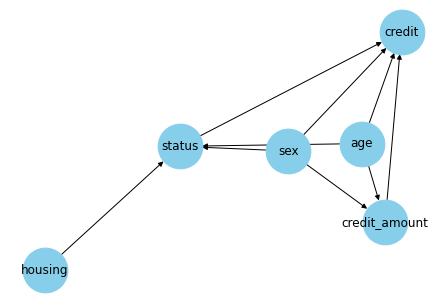

In [4]:
G = nx.DiGraph()


nodes = ['sex', 'status', 'credit_amount', 'credit', 'age', 'housing']
G.add_nodes_from(nodes)

G.add_edges_from([('sex', 'status'), ('sex', 'credit_amount'), ('sex', 'credit'),
                  ('housing', 'status'), ('age', 'status'), 
                  ('age', 'credit'), ('age', 'credit_amount'),('credit_amount', 'credit'),('status', 'credit')])


pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue")
plt.show()

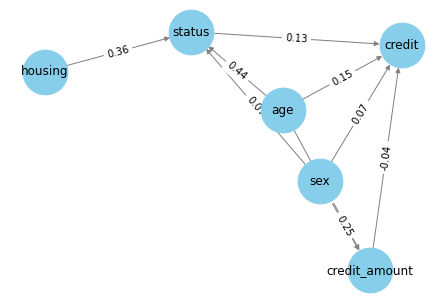

In [6]:
new_G=get_new_G(G,df)
pos = nx.spring_layout(new_G)
nx.draw(new_G, pos, with_labels=True, node_size=2000, node_color="skyblue", 
        edge_color="grey", width=1)

edge_labels = {(u, v): f"{data['weight']:.2f}" for u, v, data in new_G.edges(data=True)}
nx.draw_networkx_edge_labels(new_G, pos, edge_labels=edge_labels)
plt.show()

In [ ]:
ranks=get_ranking_query(new_G, df, 5, {'housing':1}, 'credit_amount',{'age':1},'fix')
ranks

### Simulating the ranking probility

In [ ]:
base_line(df,5)

#### Backdoor adjustment probs

### Greedy algorithm

In [13]:
var=['sex', 'status', 'credit', 'age', 'housing']

In [14]:
df_gr=Greedy_Algo(new_G, df, 5, 'credit_amount',var,0, {'age':1},100, opt="add",force=0.5)

In [15]:
df_gr

,rank,prob,total_iters
0,"[5, 18, 7, 3, 29]",0.204,102.0
1,"[5, 7, 18, 3, 29]",0.098,49.0
2,"[7, 5, 18, 3, 29]",0.098,49.0
3,"[5, 1, 7, 3, 17]",0.600,300.0


In [16]:
most_probable_elements=get_most_probable_elements(df_gr)
most_probable_elements

,element,prob,total_iters
0,3,1.0,500.0
1,5,1.0,500.0
2,7,1.0,500.0
3,18,0.4,200.0
4,29,0.4,200.0
5,1,0.6,300.0
6,17,0.6,300.0


### Calculate the Pr(r1>=theta1,r5>=theta1,r7>=theta1|given updates)

In [95]:
from pgmpy.models import BayesianNetwork
from pgmpy.inference.CausalInference import CausalInference

def find_backdoor_sets_opt(G, Y, X):
    new_G = BayesianNetwork()
    new_G.add_nodes_from(G.nodes)
    new_G.add_edges_from(G.edges)
    inference = CausalInference(new_G)
    backdoor_sets = inference.get_all_backdoor_adjustment_sets(X, Y)
    if backdoor_sets:
        min_length = min(len(s) for s in backdoor_sets)
        shortest_backdoor_sets = [s for s in backdoor_sets if len(s) == min_length]
        return shortest_backdoor_sets
    else:
        return None




def backdoor_adjustment_opt(df, Y, y, A, a, Z):
    prob = 0
    total_len = len(df)
    total_relevant_Z = 0  

    unique_Z_combinations = df[Z].drop_duplicates()
    for z_values in unique_Z_combinations.itertuples(index=False):
        mask_Z = np.ones(len(df), dtype=bool)
        for column, value in zip(Z, z_values):
            mask_Z = mask_Z & (df[column] == value)
        
        df_Z = df[mask_Z]
        df_A_a_Z = df_Z[df_Z[A] == a]

        if not df_A_a_Z.empty:
            p_Y_given_A_Z = (df_A_a_Z[Y] == y).sum() / len(df_A_a_Z)
            p_Z = len(df_Z) / total_len
            total_relevant_Z += len(df_Z)
            prob += p_Y_given_A_Z * p_Z
    if total_relevant_Z > 0:
        prob = prob * total_len / total_relevant_Z

    return prob



def get_prob_backdoor_opt(G, df, k, update_vars, target_column, condition, opt, row_indexes, theta):
    updated_df = get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
    nodes = update_vars.keys()
    results = []
    
    for node in nodes:
        bd_sets = find_backdoor_sets_opt(G, target_column, node)
        dom_y = updated_df[target_column].unique()
        dom_node = updated_df[node].unique()
        for d_y in dom_y:
            for d_n in dom_node:
                adjusted_prob = backdoor_adjustment_opt(updated_df, target_column, d_y, node, d_n, list(bd_set))
                results.append({
                    'Y': target_column, 
                    'Y_value': d_y, 
                    'X': node, 
                    'X_value': d_n, 
                    'Z': ', '.join(bd_set), 
                    'prob': adjusted_prob
                })
        prob_df = pd.DataFrame(results)

        total_prob = None
        backdoor_path = None
        for row_index in row_indexes:
            row = updated_df.iloc[row_index]                    
            prob_groups = []
            Z_groups = []
            for z in prob_df['Z'].unique():
                z_relevant_probs = prob_df[
                    (prob_df['Z'] == z) & 
                    (prob_df['Y'] == target_column) & 
                    (prob_df['Y_value'] >= theta)]
                Z_groups.append(z)
                prob_sum = 0
                for x in prob_df['X'].unique():
                    if x in row.index:  
                        x_value = row[x]
                        prob_sum += z_relevant_probs[
                            (z_relevant_probs['X'] == x) & 
                            (z_relevant_probs['X_value'] == x_value)]['prob'].sum()
                prob_groups.append(prob_sum)

            row_prob_df = pd.DataFrame({'backdoor_path':Z_groups, 'prob':prob_groups})
            row_total_prob = row_prob_df['prob'].astype(float).to_numpy()

            if total_prob is None:
                total_prob = row_total_prob
            else:
                total_prob *= row_total_prob
            backdoor_path = row_prob_df['backdoor_path'].to_list()

        if total_prob is None:
            return pd.DataFrame()
        final_df = pd.DataFrame({'prob': total_prob, 'backdoor_path': backdoor_path})

    return final_df['prob']

```latex

Algorithm: find_backdoor_sets_opt
Input: Graph G, Target Variable Y, Treatment Variable X
Output: Backdoor Sets

1. Initialize new_G as a BayesianNetwork
2. Add nodes from G to new_G
3. Add edges from G to new_G
4. Perform causal inference on new_G
5. Find all backdoor adjustment sets for X and Y
6. Return the backdoor sets



Algorithm: backdoor_adjustment_opt
Input: Dataframe df, Outcome Variable Y, Outcome Value y, Treatment A, Treatment Value a, Covariates Z
Output: Adjusted Probability

1. Initialize probability to 0
2. Calculate the total number of entries in df
3. Initialize total relevant Z to 0
4. Iterate over unique combinations of Z values
5. For each combination, filter df based on Z values
6. Further filter df for instances where A equals a
7. If filtered dataframe is not empty:
   a. Calculate the conditional probability of Y given A and Z
   b. Calculate the probability of the Z combination
   c. Update the probability sum
8. Adjust the final probability based on total relevant Z
9. Return the adjusted probability




Algorithm: get_prob_backdoor_opt
Input: Graph G, Dataframe df, Parameters k, update_vars, target_column, condition, opt, row_indexes, theta
Output: Probability Sum

1. Update df based on ranking query parameters
2. Initialize an empty list for results
3. For each node in update_vars:
   a. Find backdoor sets for the node and target_column
   b. Iterate over backdoor sets and domain values of Y and node
   c. Calculate adjusted probability for each combination
   d. Append results with calculated probabilities
4. Convert results to a dataframe
5. Initialize variables for total probability and backdoor path
6. For each row index:
   a. Calculate the probability sum for each backdoor path
   b. Update the total probability and backdoor path
7. If total probability is not None:
   a. Calculate the final probability sum
8. Return the final probability sum

```


In [87]:
get_prob_backdoor_opt(new_G, df, len(df), {'credit_amount':4}, 'credit',{'age':1},'add',[0,4,6],-np.inf)
## I can just the small one

- step1 for each back door set we have$\sum_{i=1}^{n}Pr(Y=y|X=x,Z=z_i)Pr(Z=z_i)$
- step 2 we calculate $\sum_{j=1}^{n}Pr(Y=y_i|X=x,Z)$ with $y_i \geq \theta$, 
- step 3 we calculate $\prod_{k=1}^{n}Pr(Y=y_1,y_2 ...|X=x_k)$ with $x_k$ is in the input r, 3 is not needed
- step 4 we multiply the $\prod_{L=1}^{n}Pr(Y=y_1,y_2 ...|X=x_1,x_2..., r_L)$ to get the Pr(r1>=theta1,r5>=theta1,r7>=theta1|given updates) for each backdoor path

In [ ]:
Pr(a=1,2,3 |x=2,h=3,q=2)

In [ ]:
Pr(a=1|x=2,age)
Pr(a=1,2,3|x=2,age) if a >= theta
Pr(a=1,2,3|h=3,age) if a >= theta
Pr(a=1,2,3|q=2,age) if a >= theta

prod()
if we have row index 1 with x=2,h=3,q=2

### X should be the intervention X

$\sum Pr(top k |backdoor) Pr(backdoor)$

$Pr(backdoor)$ is missing

- We have n backdoor paths, the backdoor prob is $\frac{1}{n}$

In [28]:
from collections import Counter

def get_lst_prob(lsts):
    flat_lsts = [list(lst) for lst in lsts]
    lst_counts = Counter(map(tuple, flat_lsts)) 
    total = sum(lst_counts.values())
    prob = {lst: count / total for lst, count in lst_counts.items()}
    data = {'rank': [list(lst) for lst in prob.keys()], 'prob': list(prob.values())}
    df = pd.DataFrame(data)
    return df

def Greedy_Algo(G, df, k, target_column, vars_test,thresh_hold=0,condition=None,max_iter=100, opt="add",force=0.01):
    rank_result=[]
    if opt=='add'or 'subs':
        if opt=='add':
            pos=1
        else:
            pos=-1
        for var in vars_test:
            x_up=0
            x_sd = np.abs(df[var].std() * force)*pos
            for i in range(max_iter):
                x_up+=x_sd
                new_rank=get_ranking_query(G, df, len(df), {var:x_up},target_column,condition,opt).sort_values(by=target_column,ascending=False).head(k).index
                rank_result.append(new_rank)
                
    elif opt=='multiply_by'or 'divided_by':
        if opt=='divided_by':
            def op_chang(x_sd):
                return 1/x_sd
        else:
            def op_chang(x_sd):
                return x_sd    
        for var in vars_test:
            x_up=0
            x_sd = op_chang(1+np.abs(df[var].std() * force))
            for i in range(max_iter):
                x_up*=x_sd
                new_rank=get_ranking_query(G, df, len(df), {var:x_up}, target_column,condition,opt).sort_values(by=target_column,ascending=False).head(k).index
                rank_result.append(new_rank)
    else:
        print('invalid operator, operator must be add,subs,multiply_by and divided_by')
    res=get_lst_prob(rank_result)
    filter_res=res[res['prob'] >= thresh_hold]
    filter_res['total_iters']=len(rank_result)*filter_res['prob']
    return filter_res

In [ ]:
### increase tupples, data size, but the same query, when the x axis is k, increase k leave the dataset is fixed

In [29]:
def Comp_Greedy_Algo_backdoor(row_indexes,G, df, k, target_column, vars_test,thresh_hold=0,condition=None,max_iter=100, opt="add",force=0.01):
    prob_result=[]
    
    if opt=='add'or 'subs':
        if opt=='add':
            pos=1
        else:
            pos=-1
        for var in vars_test:
            x_up=0
            x_sd = np.abs(df[var].std() * force)*pos
            for i in range(max_iter):
                x_up+=x_sd
                updated_df=get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt).sort_values(by=target_column,ascending=False)
                theta=updated_df[target_column].iloc[k-1]
                prob_backdoor=get_prob_backdoor_opt(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result.append(prob_backdoor)
                
    elif opt=='multiply_by'or 'divided_by':
        if opt=='divided_by':
            def op_chang(x_sd):
                return 1/x_sd
        else:
            def op_chang(x_sd):
                return x_sd    
        for var in vars_test:
            x_up=0
            x_sd = op_chang(1+np.abs(df[var].std() * force))
            for i in range(max_iter):
                x_up*=x_sd
                updated_df=get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt).sort_values(by=target_column,ascending=False)
                theta=updated_df[target_column].iloc[k-1] 
                prob_backdoor=get_prob_backdoor_opt(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result.append(prob_backdoor)
    else:
        print('invalid operator, operator must be add,subs,multiply_by and divided_by')
    return prob_result

```latex
Algorithm: Comp_Greedy_Algo_backdoor
Input: row_indexes, Graph G, Dataframe df, Parameter k, target_column, vars_test, 
       Optional Parameters: thresh_hold, condition, max_iter, opt, force
Output: Probability Results

1. Initialize an empty list for probability results
2. Check the optimization operation (opt) and set the position (pos) accordingly
3. For each variable in vars_test:
   a. Initialize x_up (update value for variable)
   b. Calculate standard deviation adjustment for variable
   c. For each iteration up to max_iter:
      i. Update x_up based on standard deviation adjustment
      ii. Get the updated dataframe sorted by target_column
      iii. Determine the threshold value (theta)
      iv. Calculate the backdoor probability
      v. Append the calculated probability to the result list
4. If opt is 'multiply_by' or 'divided_by':
   a. Define the operation change function (op_chang) based on opt
   b. For each variable in vars_test:
      i. Initialize x_up and calculate standard deviation adjustment
      ii. For each iteration up to max_iter:
         - Repeat steps similar to 3(i) to 3(v) using the defined operation
5. If the operator is invalid, print an error message
6. Return the list of calculated probabilities
```

In [7]:
var=['credit_amount']
df_gr=Greedy_Algo(new_G, df, 5, 'credit',var,0, {'age':1},100, opt="add",force=0.5)
df_gr

,rank,prob,total_iters
0,"[12, 17, 39, 43, 47]",0.46,46.0
1,"[39, 43, 47, 12, 17]",0.54,54.0


In [8]:
most_probable_elements=get_most_probable_elements(df_gr)
most_probable_elements

,element,prob,total_iters
0,39,1.0,100.0
1,43,1.0,100.0
2,12,1.0,100.0
3,47,1.0,100.0
4,17,1.0,100.0


In [35]:
from pgmpy.models import BayesianNetwork
from pgmpy.inference.CausalInference import CausalInference


def find_backdoor_sets_opt(G, Y, X):
    new_G = BayesianNetwork()
    new_G.add_nodes_from(G.nodes)
    new_G.add_edges_from(G.edges)
    inference = CausalInference(new_G)
    backdoor_sets = inference.get_all_backdoor_adjustment_sets(X, Y)
    if backdoor_sets:
        min_length = min(len(s) for s in backdoor_sets)
        shortest_backdoor_sets = [s for s in backdoor_sets if len(s) == min_length]
        return shortest_backdoor_sets
    else:
        return None



def backdoor_adjustment_opt(df, Y, y, A, a, Z):
    prob = 0
    total_len = len(df)
    total_relevant_Z = 0  

    unique_Z_combinations = df[Z].drop_duplicates()
    for z_values in unique_Z_combinations.itertuples(index=False):
        mask_Z = np.ones(len(df), dtype=bool)
        for column, value in zip(Z, z_values):
            mask_Z = mask_Z & (df[column] == value)
        
        df_Z = df[mask_Z]
        df_A_a_Z = df_Z[df_Z[A] == a]

        if not df_A_a_Z.empty:
            p_Y_given_A_Z = (df_A_a_Z[Y] == y).sum() / len(df_A_a_Z)
            p_Z = len(df_Z) / total_len
            total_relevant_Z += len(df_Z)
            prob += p_Y_given_A_Z * p_Z
    if total_relevant_Z > 0:
        prob = prob * total_len / total_relevant_Z

    return prob



def get_prob_backdoor_opt(G, df, k, update_vars, target_column, condition, opt, row_indexes, theta):
    updated_df = get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
    nodes = update_vars.keys()
    results = []
    
    for node in nodes:
        bd_sets = find_backdoor_sets_opt(G, target_column, node)
        for bd_set in bd_sets:
            dom_y = updated_df[target_column].unique()
            dom_node = updated_df[node].unique()
            for d_y in dom_y:
                for d_n in dom_node:
                    adjusted_prob = backdoor_adjustment_opt(updated_df, target_column, d_y, node, d_n, list(bd_set))
                    results.append({
                        'Y': target_column, 
                        'Y_value': d_y, 
                        'X': node, 
                        'X_value': d_n, 
                        'Z': ', '.join(bd_set), 
                        'prob': adjusted_prob
                    })
    prob_df = pd.DataFrame(results)
    
    total_prob = None
    backdoor_path = None
    for row_index in row_indexes:
        row = updated_df.loc[row_index]                    
        prob_groups = []
        Z_groups = []
        for z in prob_df['Z'].unique():
            z_relevant_probs = prob_df[
                (prob_df['Z'] == z) & 
                (prob_df['Y'] == target_column) & 
                (prob_df['Y_value'] >= theta)]
            Z_groups.append(z)
            prob_sum = 0
            for x in prob_df['X'].unique():
                if x in row.index:  
                    x_value = row[x]
                    prob_sum += z_relevant_probs[
                        (z_relevant_probs['X'] == x) & 
                        (z_relevant_probs['X_value'] == x_value)]['prob'].sum()
            prob_groups.append(prob_sum)

        row_prob_df = pd.DataFrame({'backdoor_path':Z_groups, 'prob':prob_groups})
        row_total_prob = row_prob_df['prob'].astype(float).to_numpy()

        if total_prob is None:
            total_prob = row_total_prob
        else:
            total_prob *= row_total_prob
        backdoor_path = row_prob_df['backdoor_path'].to_list()

    if total_prob is None:
        return pd.DataFrame()
    final_df = pd.DataFrame({'prob': total_prob, 'backdoor_path': backdoor_path})
    return final_df['prob']

def Comp_Greedy_Algo_backdoor(row_indexes,G, df, k, target_column, vars_test,thresh_hold=0,condition=None,max_iter=100, opt="add",force=0.01):
    prob_result=[]
    
    if opt=='add'or 'subs':
        if opt=='add':
            pos=1
        else:
            pos=-1
        for var in vars_test:
            x_up=0
            x_sd = np.abs(df[var].std() * force)*pos
            for i in range(max_iter):
                x_up+=x_sd
                updated_df=get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt).sort_values(by=target_column,ascending=False)
                theta=updated_df[target_column].iloc[k-1]
                prob_backdoor=get_prob_backdoor_opt(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result.append(prob_backdoor)
                
    elif opt=='multiply_by'or 'divided_by':
        if opt=='divided_by':
            def op_chang(x_sd):
                return 1/x_sd
        else:
            def op_chang(x_sd):
                return x_sd    
        for var in vars_test:
            x_up=0
            x_sd = op_chang(1+np.abs(df[var].std() * force))
            for i in range(max_iter):
                x_up*=x_sd
                updated_df=get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt).sort_values(by=target_column,ascending=False)
                theta=updated_df[target_column].iloc[k-1] 
                prob_backdoor=get_prob_backdoor_opt(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result.append(prob_backdoor)
    else:
        print('invalid operator, operator must be add,subs,multiply_by and divided_by')
    return prob_result

In [15]:
row_indexes=[12, 17, 39, 43, 47]
var=['credit_amount']
greedy_backdoor=Comp_Greedy_Algo_backdoor(row_indexes,new_G, df, 5, 'credit',var,0, {'age':1},100, opt="add",force=0.5)

In [16]:
mean_value = sum(greedy_backdoor) / len(greedy_backdoor)
print(mean_value)

0    1.0
Name: prob, dtype: float64


In [30]:
var=['credit_amount']
df_gr=Greedy_Algo(new_G, df, 5, 'credit',var,0, None,100, opt="add",force=0.5)
df_gr

,rank,prob,total_iters
0,"[0, 619, 604, 605, 606]",1.0,100.0


In [36]:
row_indexes=[0, 619, 604, 605, 606]
var=['credit_amount']
greedy_backdoor=Comp_Greedy_Algo_backdoor(row_indexes,new_G, df, 5, 'credit',var,0, None,100, opt="add",force=0.5)

mean_value = sum(greedy_backdoor) / len(greedy_backdoor)
print(mean_value)

0    0.706567
Name: prob, dtype: float64


In [19]:
find_backdoor_sets_opt(new_G,'credit','status')

[frozenset({'age', 'sex'})]

In [ ]:
var=['status']
df_gr=Greedy_Algo(new_G, df, 5, 'credit',var,0, {'age':1,'month':0},100, opt="add",force=0.5)
df_gr

,rank,prob,total_iters
0,"[0, 20, 21, 22, 24]",1.0,100.0


In [37]:
row_indexes=[0, 20, 21, 22, 24]
greedy_backdoor=Comp_Greedy_Algo_backdoor(row_indexes,new_G, df, 5, 'credit',var,0, {'age':1,'month':0},100, opt="add",force=0.5)
mean_value = sum(greedy_backdoor) / len(greedy_backdoor)
print(mean_value)

0    0.0
Name: prob, dtype: float64
